In [1]:
# import packages
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['font.size'] = 12

# Import  scikit modules
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
# NLP modules
import nltk 
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder 
import spacy
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline




In [2]:
en='en_core_web_sm'
nlp=spacy.load(en)

In [3]:
general_df=pd.read_csv('data/NSS_DS_data.thegeneral.csv')

In [4]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida


In [5]:
general_df.columns

Index(['ClaimID_RGEN', 'ExposureID_RGEN', 'ClaimLevelBody',
       'ExposureLevelBody', 'AccidentDescription', 'InjuryDescription',
       'DamageDescription', 'SeverityTypeName', 'ClaimGroup',
       'FaultRatingName', 'LossCauseName', 'CCCreateTime', 'CloseDate',
       'StateName'],
      dtype='object')

In [6]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120657 entries, 0 to 120656
Data columns (total 14 columns):
ClaimID_RGEN           120657 non-null int64
ExposureID_RGEN        120657 non-null int64
ClaimLevelBody         120657 non-null object
ExposureLevelBody      111199 non-null object
AccidentDescription    120657 non-null object
InjuryDescription      120619 non-null object
DamageDescription      120657 non-null object
SeverityTypeName       87699 non-null object
ClaimGroup             120642 non-null object
FaultRatingName        120656 non-null object
LossCauseName          120657 non-null object
CCCreateTime           120657 non-null object
CloseDate              99611 non-null object
StateName              120657 non-null object
dtypes: int64(2), object(12)
memory usage: 12.9+ MB


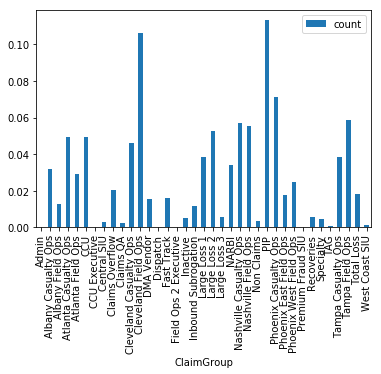

In [7]:
# severity of accidents 
claimgroup_df=general_df[['ClaimID_RGEN','ClaimGroup']].groupby('ClaimGroup').count()
# total claim
total_claim=claimgroup_df['ClaimID_RGEN'].sum()
# change it to percentage share by claimgroup
claimgroup_df['ClaimID_RGEN']=claimgroup_df['ClaimID_RGEN']/total_claim

# rename columns and then plot
claimgroup_df.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
claimgroup_df.plot(kind='bar')

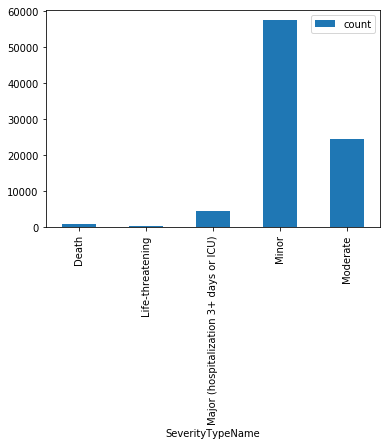

In [8]:
# severity of accidents 
severity_df=general_df[['ClaimID_RGEN','SeverityTypeName']].groupby('SeverityTypeName').count()
# rename columns and then plot
severity_df.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
severity_df.plot(kind='bar')

In [9]:
# severity of accidents 
severity_byState=general_df[['StateName','SeverityTypeName','ClaimID_RGEN']].groupby(['StateName','SeverityTypeName']).count()
severity_byState.head()

ClaimID_RGEN
StateName SeverityTypeName                                    
Alabama   Death                                             16
          Life-threatening                                  10
          Major (hospitalization 3+ days or ICU)           109
          Minor                                           1001
          Moderate                                         389

In [10]:
# rename columns and then plot
severity_byState.rename(columns={'ClaimID_RGEN':'count'},inplace=True)


In [11]:
severity_byState.head()

count
StateName SeverityTypeName                             
Alabama   Death                                      16
          Life-threatening                           10
          Major (hospitalization 3+ days or ICU)    109
          Minor                                    1001
          Moderate                                  389

In [12]:
severity_byState=severity_byState.reset_index('SeverityTypeName')

In [13]:
severity_byState.head()

,SeverityTypeName,count
StateName,,
Alabama,Death,16
Alabama,Life-threatening,10
Alabama,Major (hospitalization 3+ days or ICU),109
Alabama,Minor,1001
Alabama,Moderate,389


In [14]:
severity_byState=severity_byState.reset_index()

In [15]:
severity_byState.head()

,StateName,SeverityTypeName,count
0,Alabama,Death,16
1,Alabama,Life-threatening,10
2,Alabama,Major (hospitalization 3+ days or ICU),109
3,Alabama,Minor,1001
4,Alabama,Moderate,389


In [16]:
# major accidents by state
severity_byState_major=severity_byState[severity_byState.SeverityTypeName=='Major (hospitalization 3+ days or ICU)']
severity_byState_major=severity_byState_major.drop('SeverityTypeName',axis=1)
severity_byState_major=severity_byState_major.set_index('StateName')
severity_byState_major.head()

,count
StateName,
Alabama,109
Alaska,5
Arizona,176
Arkansas,10
California,216


In [17]:
# moderate accidents by state
severity_byState_Moderate=severity_byState[severity_byState.SeverityTypeName=='Moderate']
severity_byState_Moderate=severity_byState_Moderate.drop('SeverityTypeName',axis=1)
severity_byState_Moderate=severity_byState_Moderate.set_index('StateName')
# minor accidents by state
severity_byState_Minor=severity_byState[severity_byState.SeverityTypeName=='Minor']
severity_byState_Minor=severity_byState_Minor.drop('SeverityTypeName',axis=1)
severity_byState_Minor=severity_byState_Minor.set_index('StateName')
# death causing accidents by state
severity_byState_Death=severity_byState[severity_byState.SeverityTypeName=='Death']
severity_byState_Death=severity_byState_Death.drop('SeverityTypeName',axis=1)
severity_byState_Death=severity_byState_Death.set_index('StateName')
# life threatening accidents by state
severity_byState_Life_threatening=severity_byState[severity_byState.SeverityTypeName=='Life-threatening']
severity_byState_Life_threatening=severity_byState_Life_threatening.drop('SeverityTypeName',axis=1)
severity_byState_Life_threatening=severity_byState_Life_threatening.set_index('StateName')



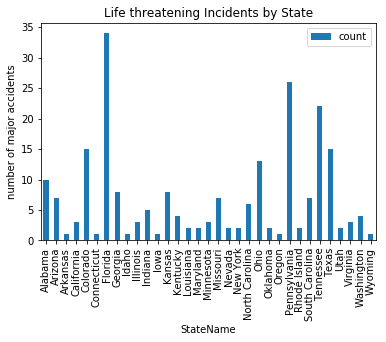

In [18]:
#plt.figure(1)
severity_byState_Life_threatening.plot(kind='bar')
plt.ylabel('number of major accidents')
plt.title('Life threatening Incidents by State')
plt.show()

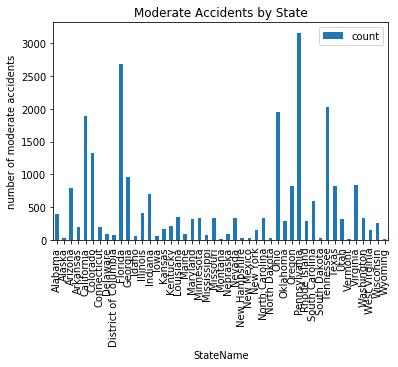

In [19]:
#plt.figure(2)
severity_byState_Moderate.plot(kind='bar')
plt.ylabel('number of moderate accidents')
plt.title('Moderate Accidents by State')
plt.show()

Text(0.5,1,'Minor Accidents by State')

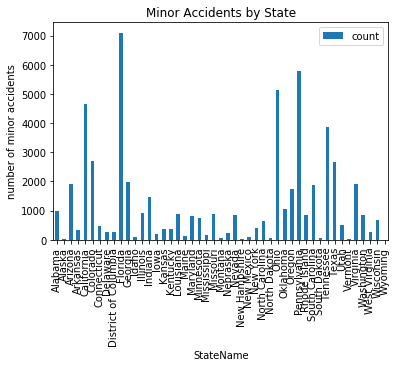

In [20]:
#plt.figure(3)
severity_byState_Minor.plot(kind='bar')
plt.ylabel('number of minor accidents')
plt.title('Minor Accidents by State')


### pennsylvania has the highest number of Major Accident types

Text(0,0.5,'number of accidents')

<Figure size 432x288 with 0 Axes>

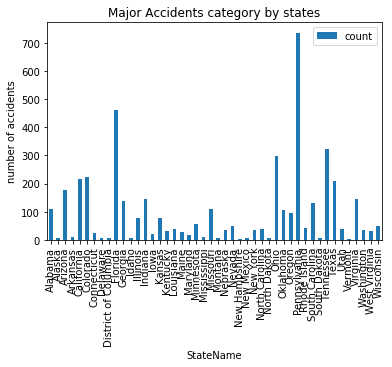

In [21]:
plt.figure(4)
severity_byState_major.plot(kind='bar')
plt.title('Major Accidents category by states')
plt.ylabel('number of accidents')

Text(0.5,1,'Death Accidents by State')

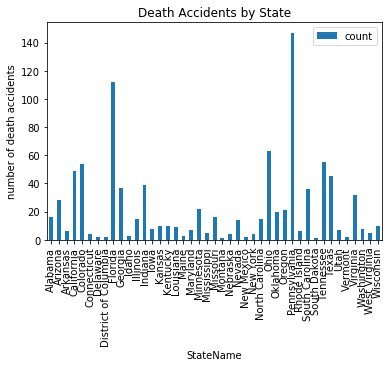

In [22]:
#plt.figure(5)
severity_byState_Death.plot(kind='bar')
plt.ylabel('number of death accidents')
plt.title('Death Accidents by State')

In [23]:
general_df['SeverityTypeName'].unique()

array(['Moderate', 'Minor', nan, 'Major (hospitalization 3+ days or ICU)',
       'Death', 'Life-threatening'], dtype=object)

In [24]:
general_df['InjuryDescription'] .dtype

dtype('O')

In [25]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120657 entries, 0 to 120656
Data columns (total 14 columns):
ClaimID_RGEN           120657 non-null int64
ExposureID_RGEN        120657 non-null int64
ClaimLevelBody         120657 non-null object
ExposureLevelBody      111199 non-null object
AccidentDescription    120657 non-null object
InjuryDescription      120619 non-null object
DamageDescription      120657 non-null object
SeverityTypeName       87699 non-null object
ClaimGroup             120642 non-null object
FaultRatingName        120656 non-null object
LossCauseName          120657 non-null object
CCCreateTime           120657 non-null object
CloseDate              99611 non-null object
StateName              120657 non-null object
dtypes: int64(2), object(12)
memory usage: 12.9+ MB


In [26]:
general_df['InjuryDescription'].dtype

dtype('O')

In [27]:
# lower the texts in the column
general_df['AccidentDescription'] = general_df['AccidentDescription'].str.lower() 

In [28]:
# remove if there is any space before and after the texts
general_df['AccidentDescription'] =general_df['AccidentDescription'].str.strip()

In [29]:
general_df['AccidentDescription'] =general_df['AccidentDescription'].replace('[^\w\s]',regex=True)


In [30]:
# let's remove stop words from tokenized words.
from nltk.corpus import stopwords

# let's download stop words
nltk.download('stopwords')
# set up stop words to enlish stop words
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fevty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### to apply spilt or word_tokenize to a column , you should change it to string type using astype(str)

In [31]:
# remove the stops words from Injury description column and assing it back to general_df

general_df['AccidentDescription'] = general_df['AccidentDescription'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

### - predict causes of loss one by one
## - mute and unmute one at a time

In [32]:
# insured vehicle rear end claimant vehicle
general_df['losscause'] = np.where(general_df['LossCauseName']=='IV rear-end CV',1,0)
# collision at intersection or others
#general_df['losscause'] = np.where(general_df['LossCauseName']=='Collision in an intersection',1,0)
# if the cause is 'Collision with motor vehicle'
#general_df['losscause'] = np.where(general_df['LossCauseName']=='Collision with motor vehicle',1,0)

In [33]:
# map severity levels to numeric
            
##general_df['LossCauseName']=general_df.SeverityTypeName.map({'Death':0,'Life-threatening':1,'Major (hospitalization 3+ days or ICU)':2,'Minor':3,'Moderate':4})


In [34]:
general_df.isna().sum()

ClaimID_RGEN               0
ExposureID_RGEN            0
ClaimLevelBody             0
ExposureLevelBody       9458
AccidentDescription        0
InjuryDescription         38
DamageDescription          0
SeverityTypeName       32958
ClaimGroup                15
FaultRatingName            1
LossCauseName              0
CCCreateTime               0
CloseDate              21046
StateName                  0
losscause                  0
dtype: int64

In [35]:
# Define X and Y

X=general_df['AccidentDescription']
y=general_df['losscause']


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report

#from sklearn.metrics import Score
#Train and evaluate the model
# fit CountVectorizer to X_train data
vect = CountVectorizer().fit(X_train)
# transform X_train data
X_train_vectorized = vect.transform(X_train)

In [37]:
# Naive Bayes model
clfrNB = MultinomialNB(alpha = 0.1)
# fit the model on vectorized data
clfrNB.fit(X_train_vectorized, y_train)
# predict loss cause
pred = clfrNB.predict(vect.transform(X_test))
# calculate score
score = metrics.accuracy_score(y_test,pred)

### Actually IV-rear-end-cv, but predcited not(FN)=1335
### Actually not IV-rear-end-cv, but predicted as iv-rear-end-cv(FP)=4485
### Actually iv-rear-end-cv, but predicted as iv-rear-end-cv(TP)=7899

In [38]:
# proportion of correct prediction to total prediction of IV-rear-end-cv 
# (i.e how much of the those identified as positives were actually positives)
TP=7899
FP=4485
precision=TP/(TP+FP)
print('precision',round((precision),2))


FN=1335
TN=22479  
# recall is how much iv-rear-end-cv was correctly predicted (i.e how much of positives were correctly identified as positives)
recall=TP/(TP+FN)
print('recall',round((recall),2))

# accuracy is the diagonal part
# cp=correct prediction
#wp=wrong prediction
#TotP=Total Predictions
cp=(22479  + 7899)
wp= (1335 +4485)
TotP=cp+wp
accuracy_score=cp/TotP
print('accuracy_score',round((accuracy_score),2))

precision 0.64
recall 0.86
accuracy_score 0.84


In [39]:
print('accuracy',round((score),2))
cm=confusion_matrix(y_test, pred)
print(cm)

auc = roc_auc_score(y_test, pred)
print('AUC',round((auc),2))

print(classification_report(y_test,pred))

accuracy 0.84
[[22479  4485]
 [ 1335  7899]]
AUC 0.84
             precision    recall  f1-score   support

          0       0.94      0.83      0.89     26964
          1       0.64      0.86      0.73      9234

avg / total       0.87      0.84      0.85     36198



In [40]:
from sklearn.utils.multiclass import unique_labels

In [41]:
# create dataframe of confusion matrix
df_confusion = pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
print(df_confusion)
# normalized confusion matrix
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_conf_norm)

Predicted      0     1
Actual                
0          22479  4485
1           1335  7899
Predicted         0         1
Actual                       
0          0.833667  0.485705
1          0.049510  0.855426


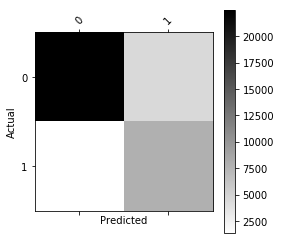

In [42]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    
    
     #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    
    
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

In [45]:
general_df['InjuryDescription_tokens']=general_df['InjuryDescription'].astype(str).apply(nltk.word_tokenize)

In [46]:
general_df['InjuryDescription_tokens'].head()

0      [neckback]
1          [pain]
2        [strain]
3          [back]
4    [neck, back]
Name: InjuryDescription_tokens, dtype: object

In [47]:
## test['tweet'].apply(lambda x: [item for item in x if item not in stop])

In [48]:
from collections import Counter

In [49]:
general_df['word_counts_InjuryDescr'] = [dict(Counter(doc)) for doc in general_df['InjuryDescription_tokens']]

In [50]:
general_df['word_counts_InjuryDescr'].head()

0           {'neckback': 1}
1               {'pain': 1}
2             {'strain': 1}
3               {'back': 1}
4    {'neck': 1, 'back': 1}
Name: word_counts_InjuryDescr, dtype: object

In [55]:
from gensim.corpora.dictionary import Dictionary 

In [56]:
#dictionary = Dictionary(general_df['InjuryDescription_tokens'])
#print(dictionary.token2id)

In [57]:
#corpus = [dictionary.doc2bow(doc) for doc in general_df['InjuryDescription_tokens']]

In [58]:
#corpus

In [59]:
# import Tfidf model from gensim.models.tfidfmodel

#from gensim.models.tfidfmodel import TfidfModel

In [60]:
# give weights to  tokens infifth line in my documents 
#tfidf=TfidfModel(corpus)
# calculate tfidf weights by passing corpus to tfidf
#tfidf[corpus[4]]

                                       count
LossCauseName                               
CV rear-end IV                          9927
Collision in an intersection           19367
Collision while backing                 3150
Collision while merging / lane change  10694
Collision while turning left            7634
Collision with a parked car             1358
Collision with bicycle / motorcycle      832
Collision with fixed object             5960
Collision with motor vehicle           17548
Collision with pedestrian               2406
Collision with train or bus              107
Damage in loading / unloading             27
Falling or moving object                 312
Fire                                      48
Glass breakage                            21
Hail                                       1
Hazardous Condition                      864
Hit and Run                             2699
IV Repossessed                             6
IV rear-end CV                         30669
IV struck 

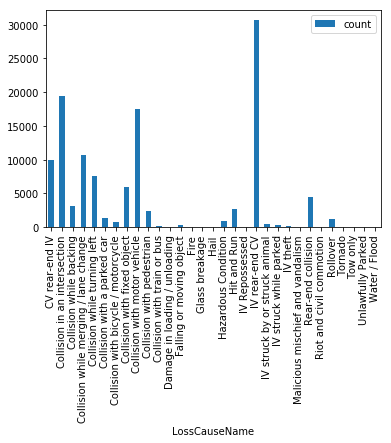

In [61]:
# cause of accidents 
cause_df=general_df[['ClaimID_RGEN','LossCauseName']].groupby('LossCauseName').count()
# rename columns and then plot
cause_df.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
print(cause_df)
cause_df.plot(kind='bar')

In [62]:
cause_df['cause_share']=(cause_df['count'])/(len(general_df))
cause_df=cause_df.drop('count',axis=1).sort_values('cause_share',ascending=False)


In [63]:
cause_df=cause_df.head(10)
cause_df.head()

,cause_share
LossCauseName,
IV rear-end CV,0.254183
Collision in an intersection,0.160513
Collision with motor vehicle,0.145437
Collision while merging / lane change,0.088631
CV rear-end IV,0.082275


Text(0.5,1,'Percentage Share of Accident Causes')

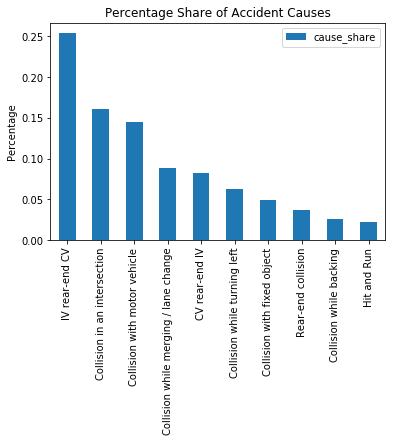

In [64]:
cause_df.plot(kind='bar')
plt.ylabel('Percentage')
plt.xlabel('')
plt.title("Percentage Share of Accident Causes")

In [65]:
len(general_df)

120657

In [66]:
general_df['LossCauseName']=general_df.LossCauseName.map

In [67]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fevty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

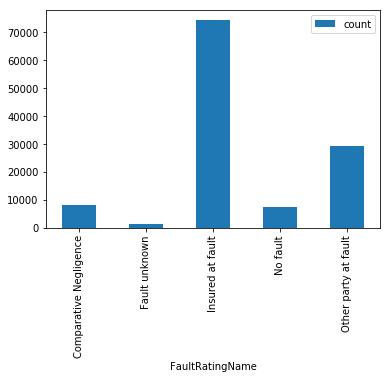

In [68]:
# who was at fault
fualts=general_df[['ClaimID_RGEN','FaultRatingName']].groupby('FaultRatingName').count()
#.rename(columns=('ClaimID_RGEN':'count',inplace=True)
fualts.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
fualts.plot(kind='bar')